Dataset downloaded successfully to: /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered
Processing images... (This may take a moment)
Total images processed: 1000
Feature vector shape: (1000, 12288)
Training SVM model... (This usually takes 1-2 minutes)
Model trained successfully!

Model Accuracy: 55.50%

Classification Report:
              precision    recall  f1-score   support

        cats       0.53      0.58      0.56        96
        dogs       0.58      0.53      0.55       104

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.56      0.56      0.55       200



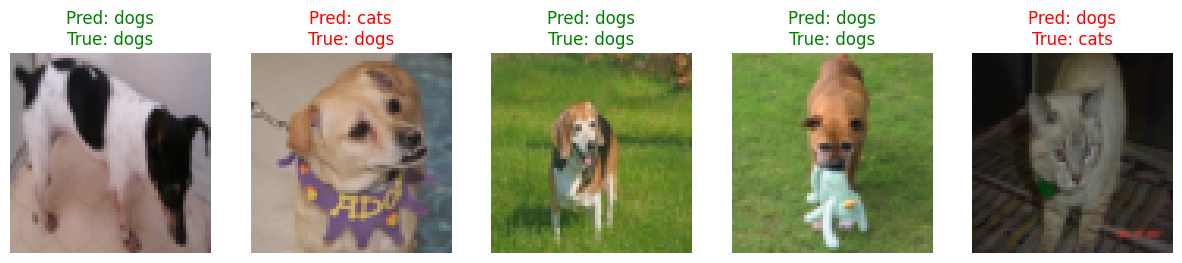

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import zipfile
import requests
from io import BytesIO
import tensorflow as tf # Added tensorflow import

# ---------------------------------------------------------
# STEP 1: LOAD DATA (FIXED)
# ---------------------------------------------------------
print("Downloading dataset...")

# We use a stable mirror URL for the 'Cats vs Dogs Filtered' dataset
url = 'https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip'

# Use TensorFlow's built-in downloader (it's much safer than wget)
# This extracts the zip file into a directory named 'cats_and_dogs_extracted' in the cache dir.
# The zip file itself contains a top-level directory 'cats_and_dogs_filtered'.
path_to_extracted_zip_root = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)

# Define directories
# The actual 'cats_and_dogs_filtered' directory is nested inside the extracted root.
base_dir = os.path.join(path_to_extracted_zip_root, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')

print(f"Dataset downloaded successfully to: {base_dir}")

# ---------------------------------------------------------
# STEP 2: PREPROCESS IMAGES
# ---------------------------------------------------------
# We need to flatten images into 1D arrays for SVM.
categories = ['cats', 'dogs']
data = []
labels = []

print("Processing images... (This may take a moment)")

for category in categories:
    path = os.path.join(train_dir, category)
    class_num = categories.index(category) # 0 for cat, 1 for dog

    # Limit to 500 images per category for speed (SVM is slow with more)
    for img in os.listdir(path)[:500]:
        try:
            img_array = imread(os.path.join(path, img))
            # Resize image to 64x64 to reduce features
            img_resized = resize(img_array, (64, 64))
            # Flatten the image
            data.append(img_resized.flatten())
            labels.append(class_num)
        except Exception as e:
            # print(f"Error processing {os.path.join(path, img)}: {e}") # Optional: uncomment for debugging specific image errors
            pass

data = np.array(data)
labels = np.array(labels)

print(f"Total images processed: {len(data)}")
print(f"Feature vector shape: {data.shape}")

# ---------------------------------------------------------
# STEP 3: SPLIT DATA
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# STEP 4: TRAIN SVM MODEL
# ---------------------------------------------------------
print("Training SVM model... (This usually takes 1-2 minutes)")
model = SVC(kernel='poly', probability=True) # Poly kernel often works well for images
model.fit(X_train, y_train)

print("Model trained successfully!")

# ---------------------------------------------------------
# STEP 5: EVALUATION
# ---------------------------------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# ---------------------------------------------------------
# STEP 6: VISUALIZATION
# ---------------------------------------------------------
# Visualize the first 5 predictions from the test set
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Reshape the flattened data back to image shape (64, 64, 3)
    img_reshaped = X_test[i].reshape(64, 64, 3)

    ax.imshow(img_reshaped)
    pred_label = categories[y_pred[i]]
    true_label = categories[y_test[i]]

    color = 'green' if pred_label == true_label else 'red'

    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    ax.axis('off')

plt.show()